# NARPS

In [1]:
%load_ext autoreload
%autoreload 2

import json
from pathlib import Path
from itertools import chain

import numpy as np
import pandas as pd

from nilearn.plotting import plot_design_matrix

import bids
from bids.modeling import BIDSStatsModelsGraph
from bids.layout import BIDSLayout

def api(obj):
    return {attr: getattr(obj, attr) for attr in dir(obj) if not attr[0] == '_'}

/home/zorro/anaconda3/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
import bids

In [3]:
layout = BIDSLayout('./ds001734/', database_path="./ds001734.db")

In [4]:
json_file = './model-narps_smdl.json'
spec = json.loads(Path(json_file).read_text())
spec

{'Name': 'NARPS',
 'Description': 'NARPS Analysis model',
 'BIDSModelVersion': '1.0.0',
 'Input': {'task': 'MGT'},
 'Nodes': [{'Level': 'Run',
   'Name': 'run',
   'GroupBy': ['run', 'subject'],
   'Transformations': {'Transformer': 'pybids-transforms-v1',
    'Instructions': [{'Name': 'Threshold',
      'Input': ['gain'],
      'Binarize': True,
      'Output': ['trials']},
     {'Name': 'Scale',
      'Input': ['gain', 'loss', 'RT'],
      'Demean': True,
      'Rescale': False,
      'Output': ['gain', 'loss', 'demeaned_RT']},
     {'Name': 'Convolve',
      'Model': 'spm',
      'Input': ['trials', 'gain', 'loss', 'demeaned_RT']}]},
   'Model': {'X': ['trials', 'gain', 'loss', 'demeaned_RT', 1], 'Type': 'glm'},
   'DummyContrasts': {'Conditions': ['trials', 'gain', 'loss'], 'Test': 't'}},
  {'Level': 'Subject',
   'Name': 'subject',
   'GroupBy': ['subject', 'contrast'],
   'Model': {'X': [1], 'Type': 'meta'},
   'DummyContrasts': {'Test': 't'}},
  {'Level': 'Dataset',
   'Name': '

In [5]:
graph = BIDSStatsModelsGraph(layout, spec)

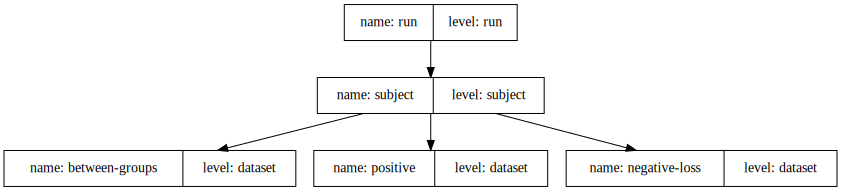

In [6]:
graph.write_graph(format='svg')

In [7]:
root_node = graph.root_node

In [8]:
try:
    graph.load_collections()
except ValueError:
    graph.load_collections(scan_length=453)  # TR = 1, nvols = 453

In [9]:
specs = root_node.run(group_by=root_node.group_by, force_dense=False)
len(specs)

432

In [10]:
api(specs[0])

{'X':        trials      gain      loss   demeaned_RT  intercept
 0    0.000002 -0.000020 -0.000011  7.939675e-07        1.0
 1   -0.000005  0.000056  0.000032 -2.276861e-06        1.0
 2    0.000014 -0.000159 -0.000091  6.446336e-06        1.0
 3   -0.000037  0.000408  0.000235 -1.654103e-05        1.0
 4    0.000073 -0.000812 -0.000468  3.296583e-05        1.0
 ..        ...       ...       ...           ...        ...
 448  0.729063  8.015666  5.652929 -2.061146e-01        1.0
 449  0.576339  7.628444  4.549625 -1.434993e-01        1.0
 450  0.397427  6.338474  3.218710 -8.201623e-02        1.0
 451  0.237071  4.844265  2.008481 -3.181046e-02        1.0
 452  0.097324  3.315304  0.939883  8.506043e-03        1.0
 
 [453 rows x 5 columns],
 'contrasts': [ContrastInfo(name='intercept', conditions=['intercept'], weights=[1], test='t', entities={'run': 1, 'subject': '001', 'contrast': 'intercept'}),
  ContrastInfo(name='loss', conditions=['loss'], weights=[1], test='t', entities={'run':

In [11]:
specs[0]

<AxesSubplot:label='conditions', ylabel='scan number'>

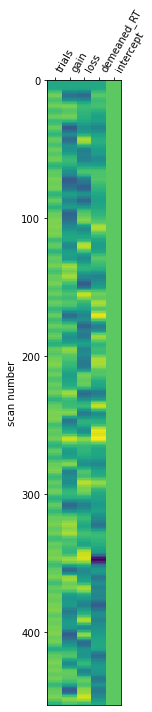

In [12]:
plot_design_matrix(specs[0].X)

In [13]:
specs[0].entities

{'run': 1, 'subject': '001'}

In [14]:
specs[0].metadata

,BandwidthPerPixelPhaseEncode,CogAtlasID,EchoTime,EffectiveEchoSpacing,FlipAngle,MagneticFieldStrength,Manufacturer,ManufacturersModelName,MultibandAccelerationFactor,PhaseEncodingDirection,...,TaskDescription,TaskName,datatype,duration,extension,onset,run,subject,suffix,task
0,34.305,http://www.cognitiveatlas.org/id/trm_4cacee4a1...,0.03,0.000275,68,3,SIEMENS,Prisma,4,j-,...,Mixed gambles task,MGT,func,1.0,.nii.gz,0.0,1,001,bold,MGT
1,34.305,http://www.cognitiveatlas.org/id/trm_4cacee4a1...,0.03,0.000275,68,3,SIEMENS,Prisma,4,j-,...,Mixed gambles task,MGT,func,1.0,.nii.gz,1.0,1,001,bold,MGT
2,34.305,http://www.cognitiveatlas.org/id/trm_4cacee4a1...,0.03,0.000275,68,3,SIEMENS,Prisma,4,j-,...,Mixed gambles task,MGT,func,1.0,.nii.gz,2.0,1,001,bold,MGT
3,34.305,http://www.cognitiveatlas.org/id/trm_4cacee4a1...,0.03,0.000275,68,3,SIEMENS,Prisma,4,j-,...,Mixed gambles task,MGT,func,1.0,.nii.gz,3.0,1,001,bold,MGT
4,34.305,http://www.cognitiveatlas.org/id/trm_4cacee4a1...,0.03,0.000275,68,3,SIEMENS,Prisma,4,j-,...,Mixed gambles task,MGT,func,1.0,.nii.gz,4.0,1,001,bold,MGT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,34.305,http://www.cognitiveatlas.org/id/trm_4cacee4a1...,0.03,0.000275,68,3,SIEMENS,Prisma,4,j-,...,Mixed gambles task,MGT,func,1.0,.nii.gz,448.0,1,001,bold,MGT
449,34.305,http://www.cognitiveatlas.org/id/trm_4cacee4a1...,0.03,0.000275,68,3,SIEMENS,Prisma,4,j-,...,Mixed gambles task,MGT,func,1.0,.nii.gz,449.0,1,001,bold,MGT
450,34.305,http://www.cognitiveatlas.org/id/trm_4cacee4a1...,0.03,0.000275,68,3,SIEMENS,Prisma,4,j-,...,Mixed gambles task,MGT,func,1.0,.nii.gz,450.0,1,001,bold,MGT
451,34.305,http://www.cognitiveatlas.org/id/trm_4cacee4a1...,0.03,0.000275,68,3,SIEMENS,Prisma,4,j-,...,Mixed gambles task,MGT,func,1.0,.nii.gz,451.0,1,001,bold,MGT


In [15]:
bold = layout.get(**specs[0].entities, suffix='bold', extension='.nii.gz')[0]

In [16]:
# import nilearn.glm
# l1m = nilearn.glm.first_level.FirstLevelModel()
# l1m.fit(bold.get_image(), design_matrices=specs[0].X)

In [17]:
next_node = root_node.children[0].destination

In [18]:
next_node.group_by

['subject', 'contrast']

In [19]:
root_node.children[0].filter

{}

In [20]:
contrasts = list(chain(*[s.contrasts for s in specs]))
sub_specs = next_node.run(contrasts, group_by=next_node.group_by)

In [21]:
api(sub_specs[3])

{'X':    intercept
 0          1
 1          1
 2          1
 3          1,
 'contrasts': [ContrastInfo(name='trials', conditions=['intercept'], weights=[1], test='t', entities={'contrast': 'trials', 'subject': '001'})],
 'data':    intercept
 0          1
 1          1
 2          1
 3          1,
 'entities': {'contrast': 'trials', 'subject': '001'},
 'force_dense': True,
 'invalid_contrasts': 'drop',
 'metadata':   contrast  run subject
 0   trials    1     001
 1   trials    2     001
 2   trials    3     001
 3   trials    4     001,
 'model_spec': <bids.modeling.model_spec.GLMMSpec at 0x7f4ba0ce5280>,
 'node': <BIDSStatsModelsNode[subject] subject>,
 'sampling_rate': 'TR'}

In [22]:
ds1_node = next_node.children[1].destination
api(ds1_node)

{'add_child': <bound method BIDSStatsModelsNode.add_child of <BIDSStatsModelsNode[dataset] negative-loss>>,
 'add_collections': <bound method BIDSStatsModelsNode.add_collections of <BIDSStatsModelsNode[dataset] negative-loss>>,
 'add_parent': <bound method BIDSStatsModelsNode.add_parent of <BIDSStatsModelsNode[dataset] negative-loss>>,
 'children': [],
 'contrasts': [{'name': 'negative',
   'condition_list': [1],
   'weights': [-1],
   'test': 't'}],
 'dummy_contrasts': False,
 'get_collections': <bound method BIDSStatsModelsNode.get_collections of <BIDSStatsModelsNode[dataset] negative-loss>>,
 'group_by': ['contrast', 'group'],
 'level': 'dataset',
 'model': {'x': [1]},
 'name': 'negative-loss',
 'parents': [BIDSStatsModelsEdge(source=<BIDSStatsModelsNode[subject] subject>, destination=<BIDSStatsModelsNode[dataset] negative-loss>, filter={'contrast': ['loss']})],
 'run': <bound method BIDSStatsModelsNode.run of <BIDSStatsModelsNode[dataset] negative-loss>>,
 'transformations': {'tran

In [23]:
next_node.children[1].filter

{'contrast': ['loss']}

In [24]:
sub_contrasts = list(chain(*[s.contrasts for s in sub_specs]))
ds1_specs = ds1_node.run(sub_contrasts, group_by=ds1_node.group_by, **next_node.children[1].filter)

In [25]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


In [26]:
ds1_specs[0].X

,intercept
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [27]:
pd.concat((ds1_specs[0].data, ds1_specs[0].metadata), axis=1)

,intercept,contrast,subject
0,1,loss,001
1,1,loss,003
2,1,loss,005
3,1,loss,009
4,1,loss,011
5,1,loss,013
6,1,loss,015
7,1,loss,017
8,1,loss,019
9,1,loss,021


In [28]:
ds1_specs[0].contrasts

[ContrastInfo(name='loss_negative', conditions=['intercept'], weights=[-1], test='t', entities={'contrast': 'loss_negative', 'group': 'equalIndifference'})]

In [29]:
ds0_node = next_node.children[0].destination 
ds0_specs = ds0_node.run(sub_contrasts, group_by=ds0_node.group_by)

In [30]:
ds0_specs

In [31]:
ds0_specs[1].X

,intercept
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [32]:
pd.concat((ds0_specs[0].data, ds0_specs[0].metadata), axis=1)

,intercept,contrast,subject
0,1,intercept,001
1,1,intercept,003
2,1,intercept,005
3,1,intercept,009
4,1,intercept,011
5,1,intercept,013
6,1,intercept,015
7,1,intercept,017
8,1,intercept,019
9,1,intercept,021


In [33]:
ds2_node = next_node.children[2].destination 
filters = next_node.children[2].filter or {}
print(filters)
ds2_specs = ds2_node.run(sub_contrasts, group_by=ds2_node.group_by, **filters)
print(ds2_specs)

{'contrast': ['loss']}


In [34]:
api(ds2_specs[0])

{'X':      C(group)[T.equalIndifference]  C(group)[T.equalRange]
 0                                1                       0
 1                                0                       1
 2                                1                       0
 3                                0                       1
 4                                1                       0
 ..                             ...                     ...
 103                              1                       0
 104                              0                       1
 105                              1                       0
 106                              1                       0
 107                              0                       1
 
 [108 rows x 2 columns],
 'contrasts': [ContrastInfo(name='loss_range_vs_indiference', conditions=['C(group)[T.equalRange]', 'C(group)[T.equalIndifference]'], weights=[1, -1], test='t', entities={'contrast': 'loss_range_vs_indiference'})],
 'data':      intercept          

In [35]:
ds2_specs[0].X

,C(group)[T.equalIndifference],C(group)[T.equalRange]
0,1,0
1,0,1
2,1,0
3,0,1
4,1,0
...,...,...
103,1,0
104,0,1
105,1,0
106,1,0


In [36]:
pd.concat((ds2_specs[0].data, ds2_specs[0].metadata), axis=1)

,intercept,group,contrast,subject,suffix
0,1,equalIndifference,loss,001,participants
1,1,equalRange,loss,002,participants
2,1,equalIndifference,loss,003,participants
3,1,equalRange,loss,004,participants
4,1,equalIndifference,loss,005,participants
...,...,...,...,...,...
103,1,equalIndifference,loss,119,participants
104,1,equalRange,loss,120,participants
105,1,equalIndifference,loss,121,participants
106,1,equalIndifference,loss,123,participants


In [37]:
api(ds1_node)

{'add_child': <bound method BIDSStatsModelsNode.add_child of <BIDSStatsModelsNode[dataset] negative-loss>>,
 'add_collections': <bound method BIDSStatsModelsNode.add_collections of <BIDSStatsModelsNode[dataset] negative-loss>>,
 'add_parent': <bound method BIDSStatsModelsNode.add_parent of <BIDSStatsModelsNode[dataset] negative-loss>>,
 'children': [],
 'contrasts': [{'name': 'negative',
   'condition_list': [1],
   'weights': [-1],
   'test': 't'}],
 'dummy_contrasts': False,
 'get_collections': <bound method BIDSStatsModelsNode.get_collections of <BIDSStatsModelsNode[dataset] negative-loss>>,
 'group_by': ['contrast', 'group'],
 'level': 'dataset',
 'model': {'x': [1]},
 'name': 'negative-loss',
 'parents': [BIDSStatsModelsEdge(source=<BIDSStatsModelsNode[subject] subject>, destination=<BIDSStatsModelsNode[dataset] negative-loss>, filter={'contrast': ['loss']})],
 'run': <bound method BIDSStatsModelsNode.run of <BIDSStatsModelsNode[dataset] negative-loss>>,
 'transformations': {'tran

In [38]:
graph.nodes

OrderedDict([('run', <BIDSStatsModelsNode[run] run>),
             ('subject', <BIDSStatsModelsNode[subject] subject>),
             ('between-groups', <BIDSStatsModelsNode[dataset] between-groups>),
             ('positive', <BIDSStatsModelsNode[dataset] positive>),
             ('negative-loss', <BIDSStatsModelsNode[dataset] negative-loss>)])

In [39]:
graph.root_node.children

[BIDSStatsModelsEdge(source=<BIDSStatsModelsNode[run] run>, destination=<BIDSStatsModelsNode[subject] subject>, filter={})]

In [40]:
graph.root_node.children[0].destination.children

[BIDSStatsModelsEdge(source=<BIDSStatsModelsNode[subject] subject>, destination=<BIDSStatsModelsNode[dataset] positive>, filter={}),
 BIDSStatsModelsEdge(source=<BIDSStatsModelsNode[subject] subject>, destination=<BIDSStatsModelsNode[dataset] negative-loss>, filter={'contrast': ['loss']}),
 BIDSStatsModelsEdge(source=<BIDSStatsModelsNode[subject] subject>, destination=<BIDSStatsModelsNode[dataset] between-groups>, filter={'contrast': ['loss']})]

In [41]:
graph.root_node.children[0].destination.children[2].destination.name

'between-groups'